# Sentiment Analysis with BlazingText

Sentiment analysis on customer reviews using Amazon SageMaker BlazingText built-in algorithm.

BlazingText is a variant of FastText which is based on word2vec.

Model will look at customer feedback and classify whether the feedback is positive (1), neutral (0), or negative (-1) sentiment.

# Import Libraries and Dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data/Womens Clothing E-Commerce Reviews.csv')

# Data Transformation

In [3]:
data.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


We are going to transform the data to contain only *review_body, product_category,* and *sentiment* to simplify the task.

In [4]:
data = data.rename(columns = {'Review Text': 'review_body',
                             'Rating': 'star_rating',
                             'Class Name': 'product_category'})

data = data[['review_body', 'star_rating', 'product_category']]

In [5]:
data.isnull().sum()

review_body         845
star_rating           0
product_category     14
dtype: int64

Drop Null Values:

In [6]:
data.dropna(inplace = True)

We want to convert the star ratings into sentiment (positive, neutral, negative). 

In [7]:
def convert_to_sentiment(rating):
    if rating in {1,2}:
        return -1
    if rating == 3:
        return 0
    if rating in {4,5}:
        return 1
    
data['sentiment'] = data['star_rating'].apply(lambda x: convert_to_sentiment(x))
data.head()

,review_body,star_rating,product_category,sentiment
0,Absolutely wonderful - silky and sexy and comf...,4,Intimates,1
1,Love this dress! it's sooo pretty. i happene...,5,Dresses,1
2,I had such high hopes for this dress and reall...,3,Dresses,0
3,"I love, love, love this jumpsuit. it's fun, fl...",5,Pants,1
4,This shirt is very flattering to all due to th...,5,Blouses,1


In [8]:
data.drop(['star_rating'], inplace = True, axis = 1)

In [9]:
data.head()

,review_body,product_category,sentiment
0,Absolutely wonderful - silky and sexy and comf...,Intimates,1
1,Love this dress! it's sooo pretty. i happene...,Dresses,1
2,I had such high hopes for this dress and reall...,Dresses,0
3,"I love, love, love this jumpsuit. it's fun, fl...",Pants,1
4,This shirt is very flattering to all due to th...,Blouses,1


# Data Exploration & Visualization

In [10]:
data.shape

(22628, 3)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22628 entries, 0 to 23485
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   review_body       22628 non-null  object
 1   product_category  22628 non-null  object
 2   sentiment         22628 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 707.1+ KB


In [12]:
data.describe()

,sentiment
count,22628.000000
mean,0.665768
std,0.657278
min,-1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


<AxesSubplot:xlabel='sentiment', ylabel='count'>

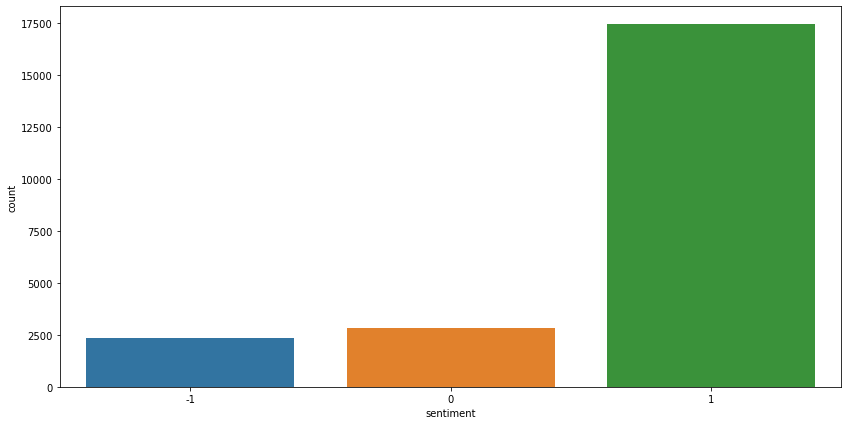

In [13]:
# sentiment class histogram
fig = plt.figure(figsize = (14,7))
sns.countplot(x = data['sentiment'])

Our dataset is heavily imbalanced with the majority of the reviews falling under the positive sentiment class.

In [14]:
data['sentiment'].value_counts()

 1    17435
 0     2823
-1     2370
Name: sentiment, dtype: int64

There are way more positive sentiment comments than neutral and negative.

Lets take a look at the average sentiment of the reviews for each product category.

In [15]:
# Plotting the average sentiment each product category gets on their reviews.
data_prodCat = data.groupby('product_category').mean().sort_values(by = 'sentiment', ascending = False)
data_prodCat.head()

,sentiment
product_category,
Chemises,1.000000
Casual bottoms,1.000000
Layering,0.780303
Jeans,0.746377
Lounge,0.745889


<AxesSubplot:ylabel='product_category'>

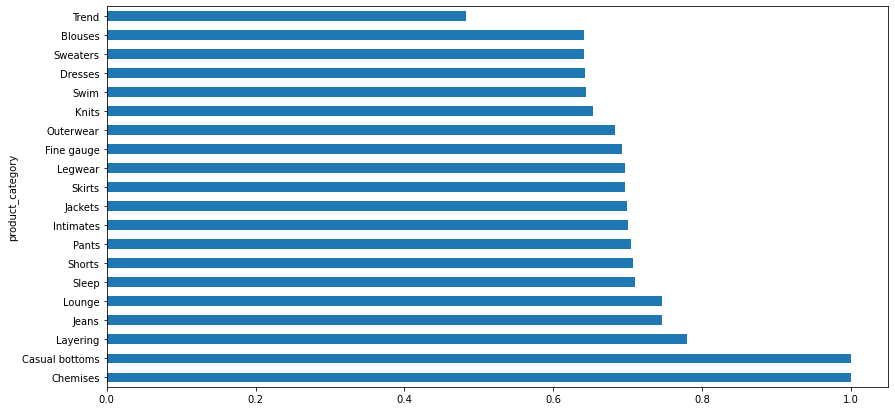

In [16]:
fig = plt.figure(figsize = (14,7))
data_prodCat.sentiment.plot(kind = 'barh')

We can see that Casual bottoms and Chemises receive very high reviews. However this could be due to the fact that there have been limited reviews written about those product categories. So whether this is the case, we can how many reviews each category has received.

Lets view how many reviews each product category has received.

<AxesSubplot:xlabel='count', ylabel='product_category'>

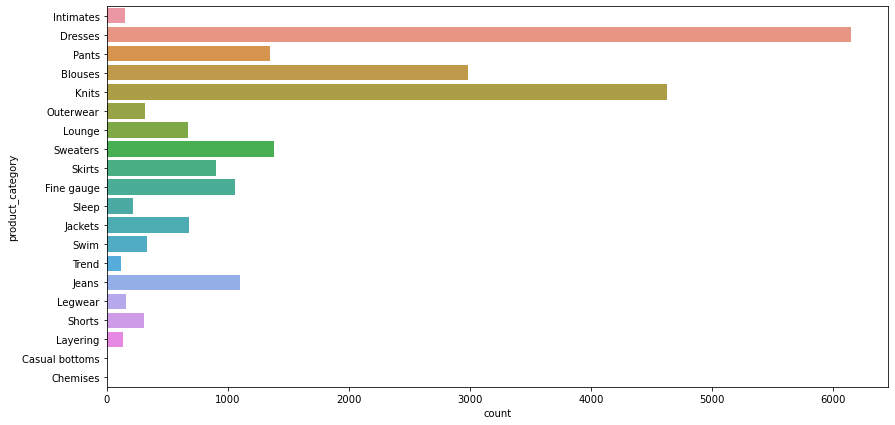

In [17]:
# Plotting the average sentiment each product category gets on their reviews.
fig = plt.figure(figsize = (14,7))
sns.countplot(data = data, y="product_category")

In [18]:
data.product_category.value_counts()

Dresses           6145
Knits             4626
Blouses           2983
Sweaters          1380
Pants             1350
Jeans             1104
Fine gauge        1059
Skirts             903
Jackets            683
Lounge             669
Swim               332
Outerwear          319
Shorts             304
Sleep              214
Legwear            158
Intimates          147
Layering           132
Trend              118
Casual bottoms       1
Chemises             1
Name: product_category, dtype: int64

This confirms our previous hypothesis that the reason why Casual bottoms and Chemises have such high mean for sentiment is because they have very limited reviews. We will remove those product categories

In [19]:
data = data.groupby('product_category').filter(lambda reviews: len(reviews) > 10)

Performing a breakdown of how many reviews of each sentiment different product categories has received.

In [20]:
# get breakdown of sentiments for each product category
data_sent_cat = data.groupby(['product_category','sentiment']).count()
data_sent_cat

review_body
product_category sentiment             
Blouses          -1                 343
                  0                 384
                  1                2256
Dresses          -1                 681
                  0                 830
                  1                4634
Fine gauge       -1                 104
                  0                 118
                  1                 837
Intimates        -1                  14
                  0                  16
                  1                 117
Jackets          -1                  72
                  0                  61
                  1                 550
Jeans            -1                  85
                  0                 110
                  1                 909
Knits            -1                 498
                  0                 605
                  1                3523
Layering         -1                  10
                  0                   9
                  1                 113
Legwear          -1                  16
                  0                  16
                  1                 126
Lounge           -1                  46
                  0                  78
                  1                 545
Outerwear        -1                  36
                  0                  29
                  1                 254
Pants            -1                 122
                  0                 154
                  1                1074
Shorts           -1                  25
                  0                  39
                  1                 240
Skirts           -1                  85
                  0                 104
                  1                 714
Sleep            -1                  23
                  0                  16
                  1                 175
Sweaters         -1                 151
                  0                 193
                  1                1036
Swim             -1                  38
                  0                  42
                  1                 252
Trend            -1                  21
                  0                  19
                  1                  78

In [21]:
product_categories = data.product_category.unique().tolist()

distribution = {}
for category in product_categories:
    distribution[category] = data_sent_cat.loc[category]['review_body'].values.tolist()

In [22]:
distribution

{'Intimates': [14, 16, 117],
 'Dresses': [681, 830, 4634],
 'Pants': [122, 154, 1074],
 'Blouses': [343, 384, 2256],
 'Knits': [498, 605, 3523],
 'Outerwear': [36, 29, 254],
 'Lounge': [46, 78, 545],
 'Sweaters': [151, 193, 1036],
 'Skirts': [85, 104, 714],
 'Fine gauge': [104, 118, 837],
 'Sleep': [23, 16, 175],
 'Jackets': [72, 61, 550],
 'Swim': [38, 42, 252],
 'Trend': [21, 19, 78],
 'Jeans': [85, 110, 909],
 'Legwear': [16, 16, 126],
 'Shorts': [25, 39, 240],
 'Layering': [10, 9, 113]}

In [23]:
# Get the percentage of sentiment classes for each product category
df_distribution = pd.DataFrame(distribution).transpose().apply(
        lambda num_sentiments: num_sentiments/sum(num_sentiments)*100, axis = 1)

df_distribution.columns = ['-1', '0', '1']
df_distribution

,-1,0,1
Intimates,9.523810,10.884354,79.591837
Dresses,11.082181,13.506916,75.410903
Pants,9.037037,11.407407,79.555556
Blouses,11.498491,12.872947,75.628562
Knits,10.765240,13.078253,76.156507
Outerwear,11.285266,9.090909,79.623824
Lounge,6.875934,11.659193,81.464873
Sweaters,10.942029,13.985507,75.072464
Skirts,9.413068,11.517165,79.069767
Fine gauge,9.820585,11.142587,79.036827


<Figure size 1008x504 with 0 Axes>

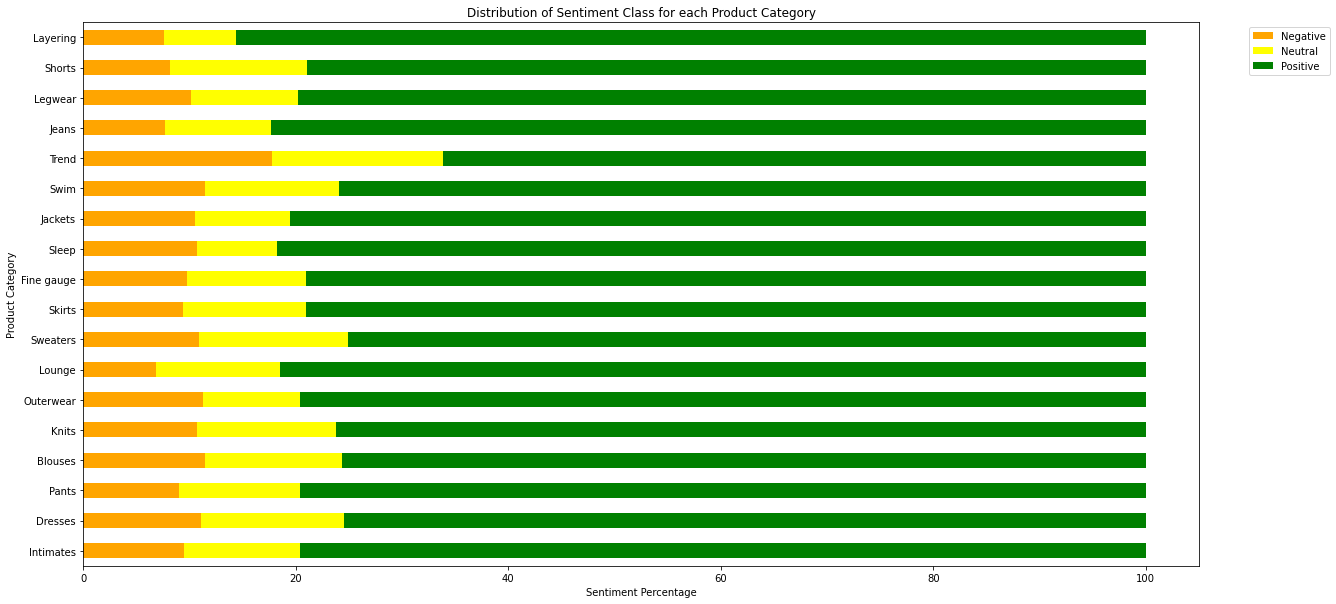

In [24]:
# Plot the distributions of sentiment class for each product category
fig = plt.figure(figsize = (14,7))

df_distribution.plot(kind = 'barh',
                     stacked = True,
                     color = ['orange', 'yellow', 'green'])

plt.title('Distribution of Sentiment Class for each Product Category')
plt.legend(labels = ['Negative', 'Neutral', 'Positive'],
          loc = 'upper left',
          bbox_to_anchor = (1.04,1))

plt.xlabel('Sentiment Percentage')
plt.ylabel('Product Category')
plt.gcf().set_size_inches(20,10)
plt.show()

We can take a look at the *review_body* feature and see what is the distribution of words per product review.

In [25]:
# Analyze the distribution of words in reviews
data_count = data.copy()
data_count['num_words'] = data_count['review_body'].apply(lambda review: len(review.split()))

In [26]:
data_count.head()

,review_body,product_category,sentiment,num_words
0,Absolutely wonderful - silky and sexy and comf...,Intimates,1,8
1,Love this dress! it's sooo pretty. i happene...,Dresses,1,62
2,I had such high hopes for this dress and reall...,Dresses,0,98
3,"I love, love, love this jumpsuit. it's fun, fl...",Pants,1,22
4,This shirt is very flattering to all due to th...,Blouses,1,36


In [27]:
# Get descriptive statistics of number of words for reviews
summary = data_count['num_words'].describe(percentiles = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00])
summary

count    22626.000000
mean        60.214665
std         28.532682
min          2.000000
10%         22.000000
20%         31.000000
30%         40.000000
40%         49.000000
50%         59.000000
60%         69.000000
70%         82.000000
80%         93.000000
90%         98.000000
100%       115.000000
max        115.000000
Name: num_words, dtype: float64

Text(0.5, 0, 'Number of Words')

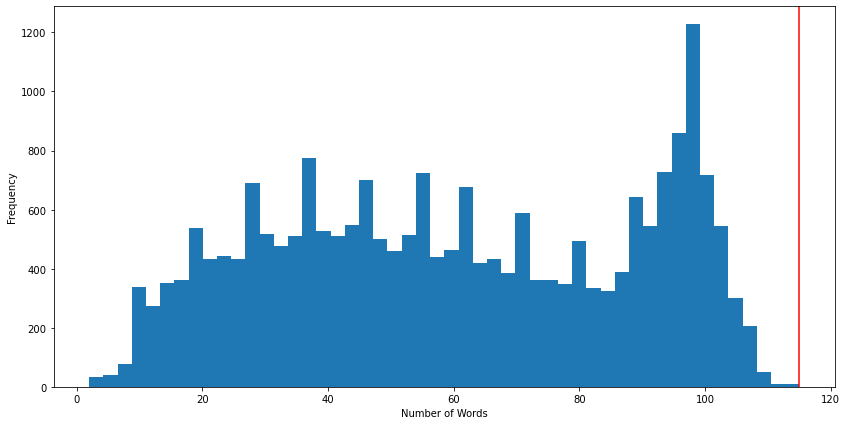

In [28]:
# Plot the distribution of number of words in reviews
plt.figure(figsize = (14,7))
data_count['num_words'].plot.hist(bins = 50).axvline(x = summary['100%'], c = 'red')

plt.xlabel('Number of Words')

Earlier we saw that there was class imbalance with the sentiment feature. We break this down by product_category

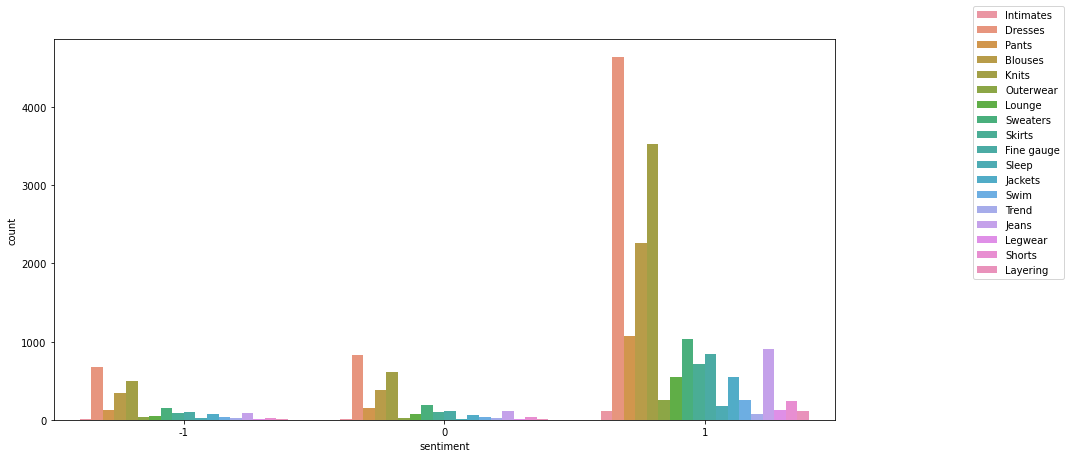

In [29]:
# Visualize the distribution of sentiment per category class
plt.figure(figsize = (14,7))
sns.countplot(data = data, x = 'sentiment', hue = 'product_category')
plt.legend(loc = 'upper right', bbox_to_anchor = (1.3,1.1))

Balance the dataset by product_category and sentiment.

In [43]:
# Balance the dataset by product_category and sentiment
data_prod_sent = data.groupby(['product_category', 'sentiment'])
data_balanced = data_prod_sent.apply(lambda x: x.sample(data_prod_sent.size().min()).reset_index(drop= True))
data_balanced

review_body  \
product_category sentiment                                                        
Blouses          -1        0  As someone with a large chest and a smaller wa...   
                           1  But it runs super small. i wear a medium for e...   
                           2  I bought this top thinking i would wear this a...   
                           3  I saw this very shirt online & thought it was ...   
                           4  Material was a tad rough for my liking. the co...   
...                                                                         ...   
Trend             1        4  This dress did not disappoint. it fits great. ...   
                           5  I love his cardigan! i knew the small would be...   
                           6  This jacket is a real treasure and i could nev...   
                           7  I liked this coat but my family said it looked...   
                           8  This dress is beautiful and unusual. i think t...   

                             product_category  sentiment  
product_category sentiment                                
Blouses          -1        0          Blouses         -1  
                           1          Blouses         -1  
                           2          Blouses         -1  
                           3          Blouses         -1  
                           4          Blouses         -1  
...                                       ...        ...  
Trend             1        4            Trend          1  
                           5            Trend          1  
                           6            Trend          1  
                           7            Trend          1  
                           8            Trend          1  

[486 rows x 3 columns]

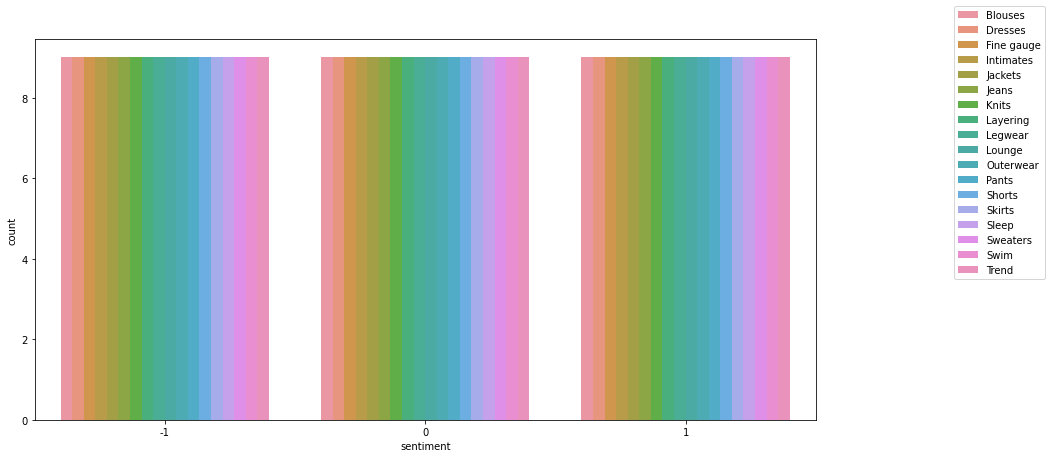

In [31]:
plt.figure(figsize = (14,7))
sns.countplot(data = data_balanced, x = 'sentiment', hue = 'product_category')
plt.legend(loc = 'upper right', bbox_to_anchor = (1.3,1.1))

We now have a balanced dataset with each product category containing the same amount of reviews belonging in each of the sentiment classes.

In [32]:
reviews = data_balanced.review_body.values.tolist()
sentiments = data_balanced.sentiment.values.tolist()

df = pd.DataFrame(list(zip(sentiments, reviews)),
                 columns = ['sentiment', 'review_body'])

In [33]:
df = df.sample(frac = 1).reset_index(drop = True)

# Data Transformation

In [34]:
df.head()

,sentiment,review_body
0,-1,Oh what a disappointment! i was looking forwar...
1,-1,"Very poorly made- wide and short, very unflatt..."
2,0,Not in love with this one. the fabric is thin ...
3,0,"I love cashmere, love the length, cowl-neck an..."
4,-1,"I bought these last year and loved them, howev..."


### Transform Data for BlazingText

In [57]:
# Transform the data for BlazingText
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

BlazingText requires the data to be in a specific format. The format that blazing looks for is:

__label__0 "this is ok"

__label__1 "this is great"

Sentiment is one of three classes: negative (-1), neutral (0), or positive (1). 

We will tokenize the review_body with nltk for the model training.

In [58]:
def tokenize(review):
    tokenized = ' '.join([str(token) for token in nltk.word_tokenize(str(review).replace(',', '').replace('"','').lower())])
    return tokenized

def transform_data(df):
    df['sentiment'] = df['sentiment'].map(lambda sentiment: '__label__{}'.format(str(sentiment).replace('__label__', '')))
    df['review_body'] = df['review_body'].map(lambda review: tokenize(review))
    return df

In [59]:
df_blazing_text = transform_data(df)
df_blazing_text.head()

,sentiment,review_body
0,__label__-1,oh what a disappointment ! i was looking forwa...
1,__label__-1,very poorly made- wide and short very unflatte...
2,__label__0,not in love with this one . the fabric is thin...
3,__label__0,i love cashmere love the length cowl-neck and ...
4,__label__-1,i bought these last year and loved them howeve...


### Split data into training and validation sets

In [60]:
# Split data into train and validation set
from sklearn.model_selection import train_test_split

X_train, y_val = train_test_split(df_blazing_text,
                                 test_size= 0.10,
                                 stratify = df_blazing_text['sentiment'])

Save the training and validation sets as CSV files.

In [62]:
# Save train and validation set into csv files
training_data_path = 'data/train.csv'
validation_data_path = 'data/validation.csv'

X_train[['sentiment', 'review_body']].to_csv(training_data_path, index = False, header = False, sep = ' ')
y_val[['sentiment', 'review_body']].to_csv(validation_data_path, index=False, header=False, sep=' ')

In [54]:
#!pip install sagemaker -U

In [37]:
import boto3
import botocore
import sagemaker


sagemaker_session = sagemaker.Session()
bucket = 'zkcawsbucket'
prefix = 'blazingText'

role = sagemaker.get_execution_role()

# Upload data to S3 Bucket

Upload training and validation set to S3 bucket. These will be used to train and validate the model.

In [63]:
# Upload training and validation data to S3 bucket
s3_blazingText_train = sagemaker_session.upload_data(bucket = bucket, key_prefix = 'blazingText/train', path = training_data_path)
s3_blazingText_validation = sagemaker_session.upload_data(bucket = bucket, key_prefix = 'blazingText/validation', path = validation_data_path)
print(s3_blazingText_train)
print(s3_blazingText_validation)


s3://zkcawsbucket/blazingText/train/train.csv
s3://zkcawsbucket/blazingText/validation/validation.csv


We will be creating an output location in S3. This will be where the model artifact will go to.

In [56]:
# Create output placeholder in S3 bucket to store outputs
output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('Training Artifacts will be uploaded to: {}'.format(output_location))

Training Artifacts will be uploaded to: s3://zkcawsbucket/autopilot/output


# Train BlazingText Model

Setup the container image to use for training with the BlazingText algorithm

In [64]:
from sagemaker.amazon.amazon_estimator import get_image_uri

container = sagemaker.image_uris.retrieve(region = boto3.Session().region_name, framework = 'blazingtext')

Set up the BlazingText model and configure the hyper-parameters for BlazingText.

In [68]:
blazing_text = sagemaker.estimator.Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type = 'ml.m5.large',
    volume_size = 30,
    max_run = 7200,
    sagemaker_session = sagemaker_session,
    output_path = output_location
)



blazing_text.set_hyperparameters(mode = 'supervised',
                                 epochs = 10,
                                 learning_rate = 0.01,
                                 min_count = 2,
                                 vector_dim = 300,
                                 word_ngrams = 3)

### Creating Traning and Validation Channels to feed model

In [69]:
# Creating training and validation channels
train_input = sagemaker.inputs.TrainingInput(s3_blazingText_train, 
                                             distribution = 'FullyReplicated', 
                                             content_type = 'text/plain',
                                             s3_data_type = 'S3Prefix'
                                            )

validation_input = sagemaker.inputs.TrainingInput(s3_blazingText_validation,
                                                  distribution = 'FullyReplicated',
                                                  content_type = 'text/plain',
                                                  s3_data_type = 'S3Prefix'
                                                 )

data_channels = {'train': train_input,
                 'validation': validation_input
                }

### Fit BlazingText Model

In [72]:
# Fit the BlazingText Model
blazing_text.fit(inputs = data_channels, wait = False)

training_job_name = blazing_text.latest_training_job.name
print('Training Job Name:  {}'.format(training_job_name))

INFO:sagemaker:Creating training-job with name: blazingtext-2022-12-28-19-32-11-410


Training Job Name:  blazingtext-2022-12-28-19-32-11-410


In [74]:
%%time 

blazing_text.latest_training_job.wait(logs=False)


2022-12-28 19:32:27 Starting - Preparing the instances for training....
2022-12-28 19:33:34 Downloading - Downloading input data....
2022-12-28 19:33:59 Training - Downloading the training image.
2022-12-28 19:34:09 Training - Training image download completed. Training in progress......
2022-12-28 19:34:40 Uploading - Uploading generated training model...........................................................
2022-12-28 19:39:46 Completed - Training job completed
CPU times: user 360 ms, sys: 22.6 ms, total: 383 ms
Wall time: 6min 33s


### Review the train and validation accuracy

In [75]:
blazing_text.training_job_analytics.dataframe()

,timestamp,metric_name,value
0,0.0,train:accuracy,0.6289
1,0.0,validation:accuracy,0.4600


Model is overfitting and the accuracy isn't the greatest. However, the purpose of this notebook isn't to fit the best model, it is to learn how to train and deploy a SageMaker built-in algorithm. If we wanted to find the optimal model we can run a hyperparamter tuning job to find the most optimal hyperparameters.

# Deploy Model

Deploy the trained model as an Endpoint.

In [76]:
# Deploy model
serializer = sagemaker.serializers.JSONSerializer()
deserializer = sagemaker.deserializers.JSONDeserializer()

classifier = blazing_text.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m5.large',
                                 serializer = serializer,
                                 deserializer = deserializer)

print('Endpoint name:  {}'.format(classifier.endpoint_name))

INFO:sagemaker:Creating model with name: blazingtext-2022-12-28-19-46-34-605
INFO:sagemaker:Creating endpoint-config with name blazingtext-2022-12-28-19-46-34-605
INFO:sagemaker:Creating endpoint with name blazingtext-2022-12-28-19-46-34-605


-----!Endpoint name:  blazingtext-2022-12-28-19-46-34-605


# Make Predictions

In [79]:
# Test Model
test_reviews = ['This product is great!', 'Ok, but not great', 'This is not the right product.']

tokenized_reviews = [' '.join(nltk.word_tokenize(review)) for review in test_reviews]

payload = {'instances': tokenized_reviews}
print(payload)

{'instances': ['This product is great !', 'Ok , but not great', 'This is not the right product .']}


In [80]:
predictions = classifier.predict(data = payload)
for prediction in predictions:
    print('Predicted Class: {}'.format(prediction['label'][0].lstrip('__label__')))

Predicted Class: 1
Predicted Class: 0
Predicted Class: 0


In [81]:
classifier.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: blazingtext-2022-12-28-19-46-34-605
INFO:sagemaker:Deleting endpoint with name: blazingtext-2022-12-28-19-46-34-605
